In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# параметры распределений
mu0, cov0 = torch.zeros(2) - 2, torch.tensor([[1,0.5],[0.5,1]]) * 2
mu1, cov1 = torch.zeros(2) + 3, torch.tensor([[1,0.5],[0.5,1]])

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
#d0 = torch.distributions.Normal(torch.tensor([mu0]), torch.tensor([sigma0]))
#d1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))
d0 = torch.distributions.MultivariateNormal(mu0, cov0)
d1 = torch.distributions.MultivariateNormal(mu1, cov1)

In [5]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.3614,  0.4764]), tensor(0.2401)]


In [6]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.603175
Ошибка после 1 итераций: 0.241874
Ошибка после 2 итераций: 0.172296
Ошибка после 3 итераций: 0.142458
Ошибка после 4 итераций: 0.124641
Ошибка после 5 итераций: 0.113620
Ошибка после 6 итераций: 0.105002
Ошибка после 7 итераций: 0.098248
Ошибка после 8 итераций: 0.091637
Ошибка после 9 итераций: 0.088802
Ошибка после 10 итераций: 0.085877
Ошибка после 11 итераций: 0.082894
Ошибка после 12 итераций: 0.080509
Ошибка после 13 итераций: 0.078166
Ошибка после 14 итераций: 0.076073
Ошибка после 15 итераций: 0.074651
Ошибка после 16 итераций: 0.071855
Ошибка после 17 итераций: 0.070751
Ошибка после 18 итераций: 0.069970
Ошибка после 19 итераций: 0.068133


In [7]:
x, y = np.mgrid[-10:10:.1, -10:10:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

d0_pdf = stats.multivariate_normal.pdf(pos, mu0, cov0)
d1_pdf = stats.multivariate_normal.pdf(pos, mu1, cov1)

x_tensor = torch.tensor(pos.reshape(-1, 2), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()
ratio = d1_pdf / (d1_pdf + d0_pdf)

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

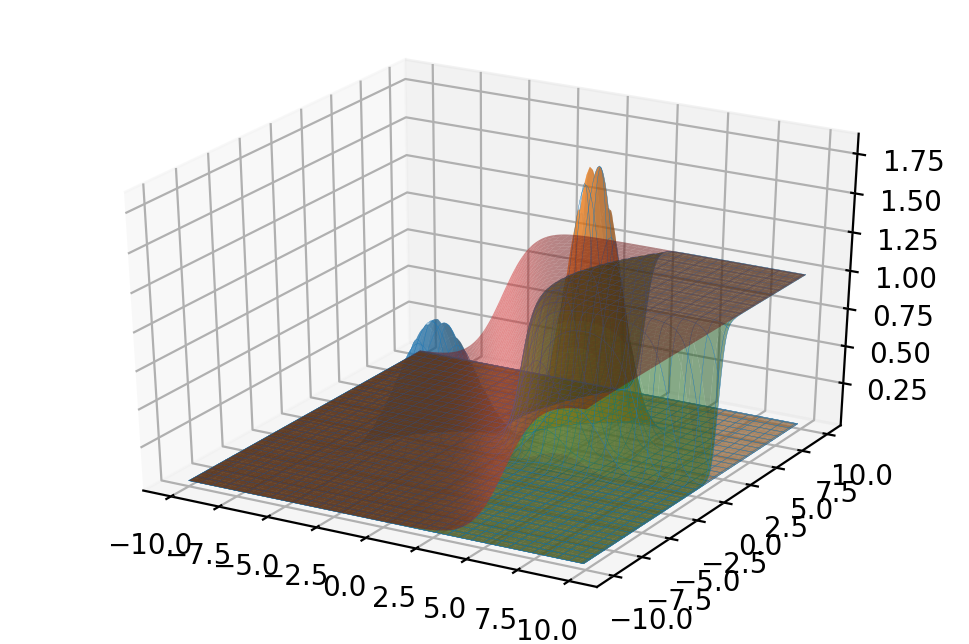

In [9]:
fig = plt.figure(dpi = 200, figsize=(6,4))
ax = fig.gca(projection='3d')

X, Y = np.meshgrid(x[:,0], y[0])

Z = d0_pdf * 10
ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha = 0.5)
ax.plot_wireframe(X, Y, Z, rstride=6, cstride=6, linewidth=0.15)

Z = d1_pdf * 10
ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha = 0.5)
ax.plot_wireframe(X, Y, Z, rstride=6, cstride=6, linewidth=0.15)

Z = ratio
ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha = 0.5)
ax.plot_wireframe(X, Y, Z, rstride=6, cstride=6, linewidth=0.15)

Z = np.reshape(dist, (-1, len(x)))
ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha = 0.5)
#ax.plot_wireframe(X, Y, Z, rstride=6, cstride=6, linewidth=0.15)

plt.show()